# **``Exploring CIFAR-10 Image Analysis with SIFT Descriptors: A Guide and Observations``**.

[Back to Main](../Project.ipynb)

SIFT (Scale-Invariant Feature Transform) is a powerful algorithm in computer vision used to detect and describe local features in images. It's often utilized in tasks like object recognition, image stitching, and more. SIFT is particularly valuable because of its invariance to image scale, rotation, and to some extent, changes in viewpoint and illumination.

For the CIFAR-10 dataset, using SIFT might be a bit challenging due to the small size of the images (32x32 pixels), which could result in a limited number of keypoints and descriptors. Nevertheless, it can still be applied.

## **Initial Setup and Data Loading:**

In this initial section, we set up our environment by importing the necessary libraries. We then proceed to load the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60,000 images distributed across ten classes, with each image having a resolution of 32x32 pixels. After loading, we can visualize a few samples to get a sense of the data.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import mode

**Load CIFAR-10 Dataset**:

In [2]:
from keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

## **Apply SIFT on an Image**:

Scale-Invariant Feature Transform (SIFT) is an algorithm in computer vision to detect and describe local features in images. Here, we initialize the SIFT detector and apply it to our dataset. We convert images to grayscale as SIFT operates on single-channel images. After applying SIFT, we can visualize the keypoints it detects on our sample images. These keypoints represent distinctive regions in the image.

In [3]:
# Initialize SIFT detector
sift = cv2.SIFT_create()
# Convert image to grayscale
gray = cv2.cvtColor(train_images[499], cv2.COLOR_BGR2GRAY)
# Detect keypoints and descriptors
keypoints, descriptors = sift.detectAndCompute(gray, None)

**Visualize Keypoints**:
   To visualize the keypoints on the image:

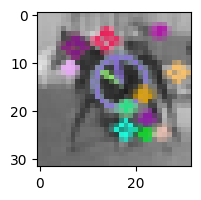

In [4]:
img_with_keypoints = cv2.drawKeypoints(gray, keypoints, outImage=np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(3, 2))
plt.imshow(img_with_keypoints)

## **Feature Extraction for the Entire Dataset:**

Given the nature of the SIFT algorithm, the number of keypoints and descriptors can vary across images. To address this, we iterate through the entire dataset to extract these descriptors. Accumulating these descriptors will allow us to cluster them in the next steps, leading to a consistent feature representation.

In [5]:
all_descriptors = []
for img in train_images[:100]:  # Here are the first 100 images for demonstration
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        all_descriptors.extend(descriptors)


### **Building Histograms for Images:**

For each image, we'll assign its descriptors to the closest cluster center and then build a histogram.
Once our KMeans model is trained on the descriptors, we can build histograms for each image. Each histogram's bin represents a cluster, and the value in each bin indicates the number of descriptors from the image that fall into that cluster. This histogram serves as the feature vector for our images.

### Collect all the descriptors from a subset of images in CIFAR-10

First, we'll gather all the descriptors from a subset of the CIFAR-10 dataset and convert them to `float32`.

In [6]:
all_descriptors = []

for img in train_images[:1000]:  # Taking a subset for efficiency
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        all_descriptors.extend(descriptors)

all_descriptors = np.float32(all_descriptors)


### **Clustering SIFT Descriptors:**
One common approach to deal with varying number of descriptors across images is to cluster them. This way, we can represent each image with the frequency (or histogram) of each cluster, which is consistent in size. A popular algorithm for this task is KMeans.
To handle the varying number of descriptors for each image, we employ clustering. By clustering the descriptors, we can represent each image by a histogram of cluster frequencies. This representation ensures that every image, regardless of its content, will have a consistent feature size. In this section, we use the KMeans algorithm, a popular choice for clustering tasks.

#### Train the KMeans model using these descriptors

In [7]:
# Number of clusters
k = 100

# Using KMeans to cluster the descriptors into 'k' clusters
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(all_descriptors)

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=100, random_state=0)

### Use the trained KMeans model to predict cluster assignments for the images

Now, we can use the trained KMeans model to generate histograms for the images.

In [8]:
image_histograms = []

for img in train_images[:100]:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    
    if descriptors is not None:
        histogram = np.zeros(k)
        
        # Convert descriptors to float32
        descriptors = np.float32(descriptors)
        
        cluster_result = kmeans.predict(descriptors)
        
        for i in cluster_result:
            histogram[i] += 1.0
            
        image_histograms.append(histogram)

## **Using Histograms for Classification:**
Once we have consistent-sized histograms for each image, they can be used as features for classification or other tasks. For instance, you can train a classifier using these histograms as input features.

### Visualizing Some Histograms:
Let's visualize histograms for some images.

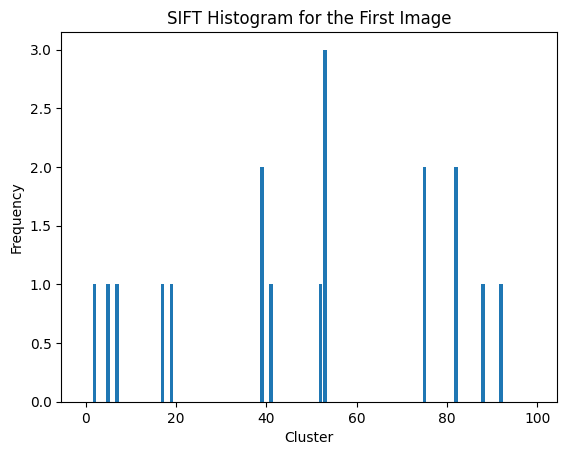

In [9]:
# Displaying histogram for the first image
plt.bar(range(k), image_histograms[0])
plt.title("SIFT Histogram for the First Image")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.show()

## **Image Similarity using Histograms:**
One of the primary uses of these histograms is to measure the similarity between images. A simple approach is to use a metric like the chi-squared distance between histograms:

$$
\chi^2(p, q) = \sum \frac{(p_i - q_i)^2}{p_i + q_i}
$$

Where \( p \) and \( q \) are two histograms. A smaller value indicates the histograms (and thus the images) are more similar.

In [10]:
def chi_squared_distance(histA, histB, eps=1e-10):
    return 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(histA, histB)])

# Example: Compute the distance between the first and second image
distance = chi_squared_distance(image_histograms[0], image_histograms[1])
print(f"Chi-Squared Distance between first and second image: {distance}")

Chi-Squared Distance between first and second image: 14.666666665511109


Observing the result "Chi-Squared Distance between first and second image: 14.666666665511109", mean the computed chi-squared distance between the histograms of the first and second images.

## **Image Classification using Histograms:**
The histograms can serve as input features for a classifier, such as a Support Vector Machine (SVM) or a neural network. Given labeled training data, we can train these classifiers to recognize content in the images based on their histograms. With our histograms serving as consistent-sized features for each image, we can use them for classification tasks. In this section, we employ a RandomForest classifier to distinguish between different image classes based on their SIFT histograms.

In [11]:
# Assuming we have labels for our images
labels = train_labels[:100]

X_train, X_test, y_train, y_test = train_test_split(image_histograms, labels, test_size=0.25, random_state=42)

model = SVC(kernel="linear", C=0.025)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.12      1.00      0.21         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4

    accuracy                           0.12        25
   macro avg       0.01      0.10      0.02        25
weighted avg       0.01      0.12      0.03        25



c:\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and be

#### **Observations on Image Classification using Histograms:**

From the results of the classification report, we can draw the following insights:

1. **Low Overall Accuracy**: The model has an overall accuracy of 0.12, which means it correctly predicted the class of 12% of the images in the test set. This is a low accuracy, suggesting that the model struggled to differentiate between different classes based on their SIFT histograms.
 
2. **Skewed Predictions for Class 1**: The model seems to have a bias towards predicting images as belonging to class 1. It has a precision of 0.12 for this class, but more notably, a recall of 1.00, suggesting that it correctly identified all instances of class 1 in the test set but also misclassified other images as class 1.

3. **Zero Recall for Most Classes**: The recall for all classes except class 1 is 0, meaning the model failed to correctly identify any instance of these classes in the test set.

4. **Issues with F1-Score**: The F1-score, which is the harmonic mean of precision and recall, is also low for all classes, indicating poor overall performance. For most classes, it's at 0.00, and for class 1, it's at 0.21.

### **Utilizing SIFT Histograms for Image Classification**:

Armed with the SIFT histograms as features representing our images, we are positioned to embark on an image classification journey. The process involves training a model using a part of the dataset (training set) and then evaluating its performance on a separate, unseen part (testing set). Random Forest, a versatile and widely used ensemble learning method, is our chosen classifier for this task.

**Data Segmentation into Training and Testing Sets**:

Before initiating the training of our model, it's paramount to partition our dataset. This split ensures that after training our model on a subset of the data, we have a fresh, untouched batch (testing set) to evaluate its performance. The aim is to gauge how well our model generalizes to new, unseen data.

**Inspecting the Data Dimensions**:

Ensuring the correct shape and size of our datasets is crucial. By printing the shapes of our training and testing sets, we affirm that the data is segmented as intended. It's a quick check to confirm we're on the right track and the data is ready for the subsequent modeling steps.

In [12]:
# Convert image_histograms to a NumPy array
image_histograms_array = np.array(image_histograms)

# Assuming `image_histograms` contain the histograms of the images and `train_labels` are the labels
labels = train_labels[:len(image_histograms_array)]

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(image_histograms_array, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)


(80, 100) (20, 100)


The result is: 80% of the data for training and 20% for testing data set.

### **Training a Classifier**

Next, we would train a classifier on our training dataset. For this example, we can use the `RandomForestClassifier` from the `sklearn` library, which tends to perform well on a wide range of tasks without requiring much hyperparameter tuning.

The crux of machine learning is the training phase. At this juncture, we employ the RandomForest Classifier, renowned for its ability to handle complex datasets without an explicit need for fine-tuning. By feeding it our training data, the model learns to discern patterns and intricacies which enable it to categorize images based on their SIFT features. The `n_estimators` parameter designates the number of trees in the forest, a factor that can influence the robustness of the predictions. The `random_state` ensures reproducibility of results.

In [13]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

C:\Users\baal_\AppData\Local\Temp\ipykernel_61028\1822231410.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### **Evaluating Classifier Performance**:

Description:
Once our model is trained, its true mettle is tested on unseen data. This is where we evaluate the RandomForest classifier by predicting labels for our test dataset. The accuracy score, representing the fraction of correct predictions over total predictions, serves as a straightforward metric to gauge the model's capability. A higher accuracy percentage indicates that our model is adept at recognizing and categorizing images based on the derived SIFT features.

In [14]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 5.00%


### **Demo visualizing Image Features through Histograms**:

Below, we present a side-by-side comparison demo for a selection of images from our dataset:

- **Original Images**: The untouched visual content, as seen in the dataset.
- **SIFT Histograms**: Highlighting the distribution of SIFT features across different clusters. This histogram provides insights into the dominant patterns and structures within the image.
- **Color Histograms**: Depicting the distribution of pixel intensities across the RGB channels. It offers a perspective on the color composition of the image.

By juxtaposing these visuals, we aim to underline the relationship between an image and its abstracted features.

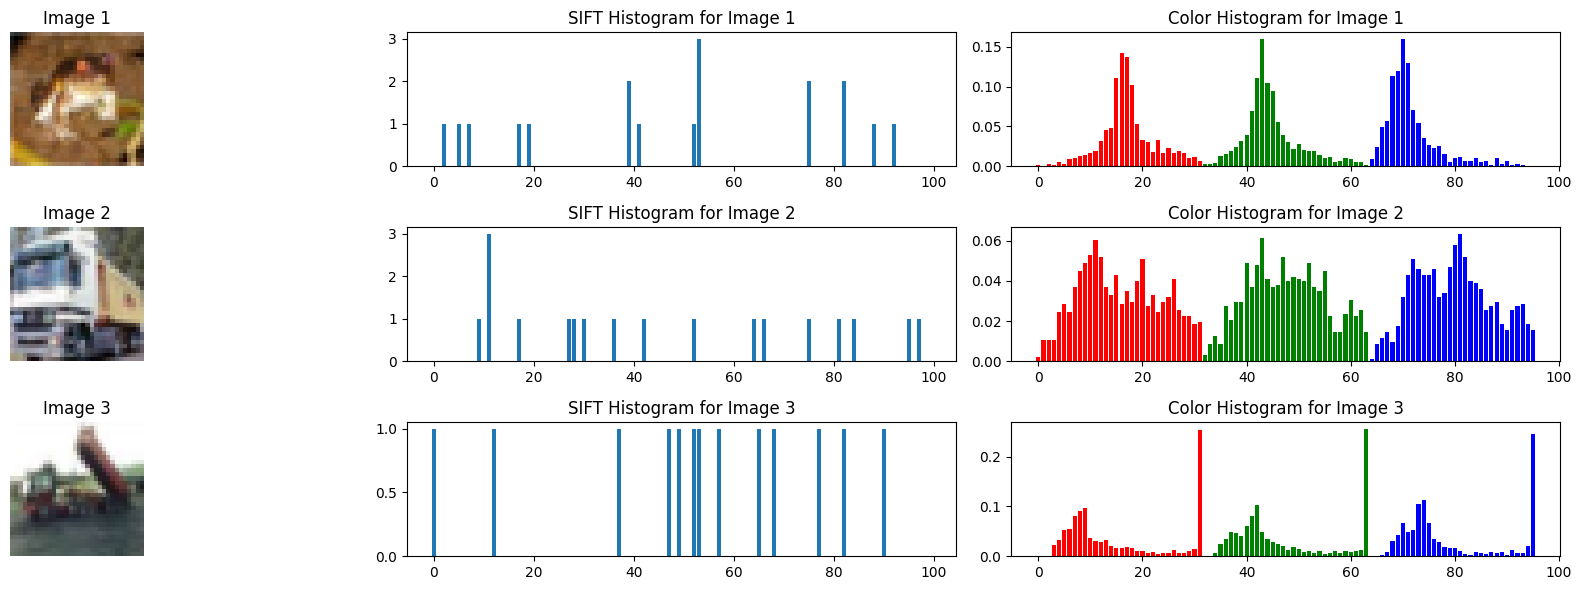

In [15]:
# Function to plot the histogram alongside the actual image
def plot_image_and_histogram(image, histogram, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the image
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis('off')

    # Plot the histogram
    axs[1].bar(range(k), histogram)
    axs[1].set_title("SIFT Histogram")
    axs[1].set_xlabel("Cluster")
    axs[1].set_ylabel("Frequency")
    axs[1].set_yscale("log")
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def compute_color_histogram_demo(image, bins=32):
    # Compute histogram for each channel separately
    hist_r = cv2.calcHist([image], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [bins], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [bins], [0, 256])
    
    # Normalize the histograms
    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()
    
    # Concatenate histograms into a single feature vector
    histogram = np.concatenate([hist_r, hist_g, hist_b]).flatten()
    return histogram

# Compute color histograms for all images
color_histograms = [compute_color_histogram_demo(img) for img in train_images[:len(image_histograms_array)]]

# Plot for the first three images and their histograms
# Visualizing both the image and its corresponding SIFT histogram side by side for the first 3 images

fig, axes = plt.subplots(3, 3, figsize=(18, 6))

# Iterate over first 3 images
for idx, img in enumerate(train_images[:3]):
    
    # Display the image
    axes[idx, 0].imshow(img)
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title(f"Image {idx+1}")
    
    # Display the SIFT histogram
    axes[idx, 1].bar(range(k), image_histograms[idx])
    axes[idx, 1].set_title(f"SIFT Histogram for Image {idx+1}")
    
    # Display the color histogram
    axes[idx, 2].bar(range(3*32), color_histograms[idx], color=['red']*32 + ['green']*32 + ['blue']*32)
    axes[idx, 2].set_title(f"Color Histogram for Image {idx+1}")

plt.tight_layout()
plt.show()


### **Observations:**

1. **Consistent Feature Size**: One of the primary advantages of using SIFT histograms as features is the consistent feature size across different images. This makes it easier to feed them into most machine learning algorithms.
   
2. **Abstract Representation**: The histograms give an abstract representation of the images, capturing their essential characteristics. This is particularly useful when the dataset has a lot of variance.
   
3. **Versatility**: These histograms can be used for various tasks beyond classification, such as image retrieval or clustering.

---

## **In-depth Visual Analysis of Keypoints:**

**Objective**: 
To delve deeper into the nature of keypoints, we aim to comprehend their distribution across various classes. By doing so, we might uncover patterns that determine the frequency and distribution of these keypoints in different types of images.

### **Calculate the Average Number of Keypoints for Each Class:**

We'll define a function that extracts the keypoints for images of a specific class:

In [16]:
def average_keypoints_for_class(class_idx, num_samples=1000):
    """
    Calculate the average number of keypoints for a given class using SIFT.
    
    Parameters:
    - class_idx: The class index for which we want to calculate the average number of keypoints.
    - num_samples: Number of samples to consider for the computation (default is 1000 for efficiency).
    
    Returns:
    - Average number of keypoints for the class.
    """
    # Filter images of the specified class
    class_images = train_images[train_labels.flatten() == class_idx][:num_samples]
    
    total_keypoints = 0
    
    for img in class_images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, _ = sift.detectAndCompute(gray, None)
        total_keypoints += len(keypoints)
    
    return total_keypoints / len(class_images)

# Calculate average keypoints for each class in CIFAR-10
avg_keypoints_per_class = [average_keypoints_for_class(i) for i in range(10)]

### **Visualizing the Average Keypoint Distribution Across Classes:**

**Objective**: 
To ascertain which classes tend to have a higher concentration of keypoints on average.

Using the CIFAR-10 dataset, we've computed the average number of keypoints for each class. Here, we'll use a bar chart to visualize this distribution.

The `class_names` list provides a reference to the class labels in the CIFAR-10 dataset. Our visualization leverages a bar chart where the x-axis represents the classes and the y-axis depicts the average number of keypoints. This gives a clear comparative view of keypoint distribution across classes.

The color `skyblue` offers a pleasant aesthetic to the chart, ensuring that the data remains the focal point. For better readability, class names on the x-axis are rotated at 45 degrees.

By studying this chart, we can discern which classes tend to have more distinguishable features on average. A class with a higher average number of keypoints might be rich in textures and structures, making it more distinctive. Conversely, a class with fewer keypoints could either be more uniform in texture or less distinctive in the context of the entire dataset. Such insights can be pivotal when considering feature extraction strategies or data augmentation techniques.

Now, let's visualize the average number of keypoints detected for each class in the CIFAR-10 dataset:

Average Number of Keypoints Detected for Each Class: [10.328, 14.317, 10.676, 13.649, 12.203, 14.98, 13.233, 15.307, 10.123, 15.225]


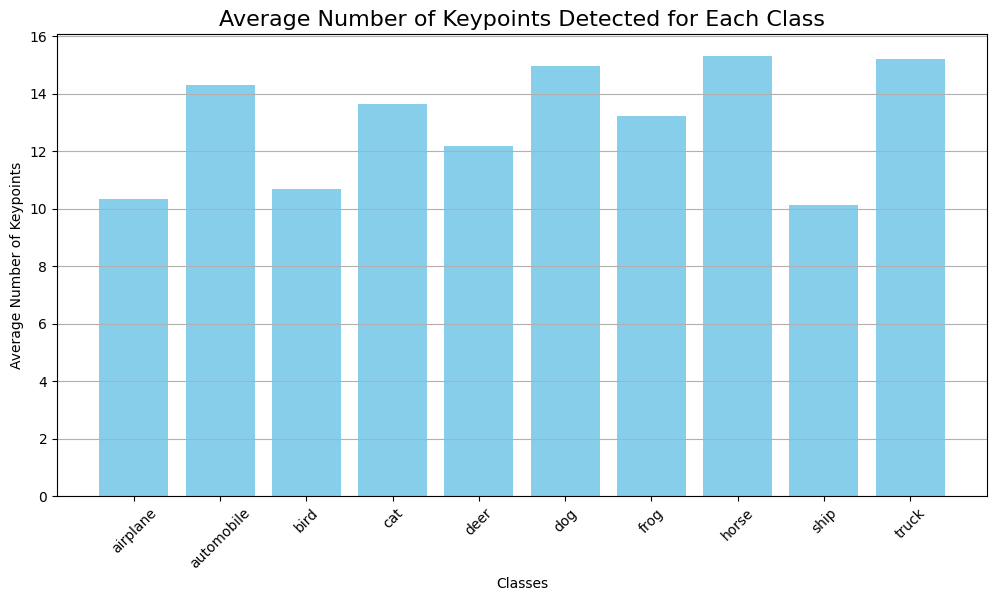

In [17]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

print('Average Number of Keypoints Detected for Each Class:', avg_keypoints_per_class)

plt.figure(figsize=(12, 6))
plt.bar(class_names, avg_keypoints_per_class, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Average Number of Keypoints')
plt.title('Average Number of Keypoints Detected for Each Class', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### **Observations:**

From the bar chart, we can derive the following insights:

1. **Differences between classes**: Certain classes like 'horse', 'truck', and 'dog' have a higher average number of keypoints compared to others. This might indicate that images in these classes have more distinctive regions, possibly due to complex textures, shapes, or intricate details present in the images. 

2. **Class difficulty**: Classes such as 'airplane', 'bird', and 'ship' have a relatively lower number of keypoints. This suggests that these images might be simpler in texture or have more uniform regions, making them potentially challenging for a SIFT-based descriptor to capture enough unique features for robust classification.

3. **Consistency across similar classes**: Classes that are somewhat related in terms of their inherent features, such as 'automobile' and 'truck', show similar keypoint counts. This can be attributed to the similarity in shapes, structures, and textures present in these categories.

4. **Potential for Augmentation**: Classes with fewer keypoints might benefit from data augmentation techniques that introduce more variety or emphasize specific features, thereby potentially increasing the number of detectable keypoints and improving classification performance.

5. **Impact on Classification**: While a higher number of keypoints might indicate more information, it doesn't necessarily guarantee better classification performance. It's essential to ensure that the keypoints detected are indeed representative of the class-specific features and not just random noise.

Incorporating these observations, it would be beneficial to examine the classification performance across different classes and potentially tailor the feature extraction or preprocessing methods to address the nuances of each class.


These observations help in understanding the nature of the dataset and the kind of features SIFT is extracting. It sets a foundation for further experimentation and refinement of the image processing pipeline.

---

## **Analyzing Keypoints on Random Images from Different Classes:**

**Objective**:
To offer a detailed visual analysis of the distribution and characteristics of keypoints detected across different categories of images.

In the image processing domain, especially when working with feature extraction techniques like SIFT, understanding where and how keypoints are detected across various images is crucial. This is because the effectiveness of the extracted features plays a pivotal role in subsequent tasks like image matching or classification.

For this analysis, we've randomly chosen images spanning the range of classes in the CIFAR-10 dataset. The subsequent steps involve:
1. Converting each image to grayscale, as SIFT works predominantly on single-channel images.
2. Employing the SIFT algorithm to detect distinct keypoints and their associated descriptors.
3. Overlying these detected keypoints on the original image. The visual representation uses circles where the circle's size indicates the keypoint's scale, and its orientation showcases the keypoint's angle.

From this visual assessment, several patterns and observations can be made:
- **Regions of Interest**: It's apparent that SIFT gravitates towards regions in images that depict significant texture variations, edges, or other distinctive patterns. For instance, in images of animals, the keypoints might concentrate around the eyes, fur patterns, or the outline of the animal.
- **Dense vs. Sparse Distribution**: Some images might have a denser collection of keypoints, perhaps due to the presence of intricate details, while others might be sparser, possibly indicating uniformity in texture or color.
- **Scale and Orientation**: Observing the scale and orientation of keypoints might hint at the underlying texture or the structural elements of the image. For instance, larger circles might indicate broader features, while the orientation might suggest patterns like stripes or edges.

Concluding, this granular analysis offers valuable insights into the behavior of the SIFT algorithm on our dataset. Recognizing the regions in images that SIFT deems significant can be instrumental in refining preprocessing steps or even in augmenting the dataset to emphasize these regions further.

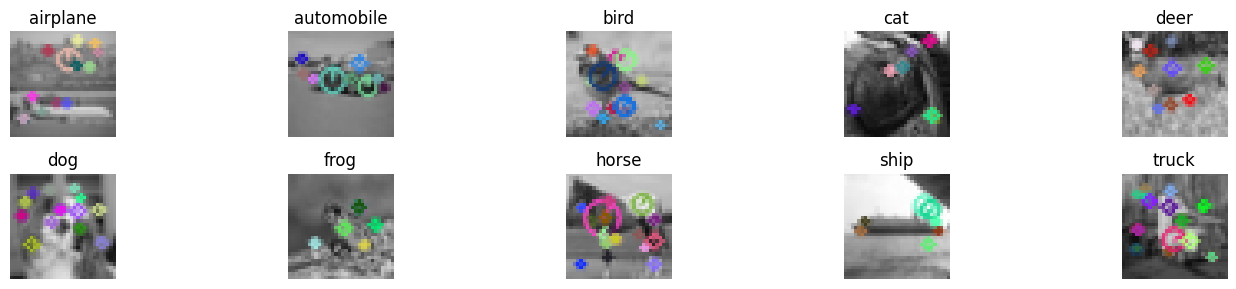

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(15, 3))

for i, ax in enumerate(axes.flat):
    random_img = train_images[train_labels.flatten() == i][np.random.randint(0, 5000)]
    gray = cv2.cvtColor(random_img, cv2.COLOR_BGR2GRAY)
    keypoints, _ = sift.detectAndCompute(gray, None)
    img_with_keypoints = cv2.drawKeypoints(gray, keypoints, outImage=np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax.imshow(img_with_keypoints)
    ax.set_title(class_names[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

### **Observations:**

1. **Distribution**: The keypoints are not uniformly distributed across the image. They tend to cluster around regions with distinct textures or features.
2. **Variability**: Even within the same class, the number and distribution of keypoints can vary significantly based on the specific image's content.
3. **Size and Orientation**: Keypoints also capture scale and orientation, which is evident from their varied sizes and angles.

### **In-Depth Analysis of Histograms:**

Histograms, in the context of SIFT descriptors, provide a compact yet informative representation of images. Each histogram captures the frequency of visual words (or clustered descriptors) present in an image. Analyzing these histograms can offer valuable insights into the distribution and prominence of different visual patterns across our dataset.

#### **Distribution of Descriptors Across Clusters:**

Understanding the distribution of SIFT descriptors across the various clusters or "visual words" can be insightful for several reasons:

1. **Prominent Features**: If certain clusters (or bins in the histogram) have a high frequency, it indicates that the visual features associated with those clusters are common across the dataset. For instance, if we're working with a dataset of natural images, clusters corresponding to features like sky, grass, or water might be more prominent.

2. **Diversity of Features**: A more uniform distribution suggests that the dataset possesses a wide variety of visual features, whereas a skewed distribution might hint at repetitive or dominant patterns.

3. **Dataset Biases**: If only a few clusters dominate the histograms, it could either mean that those features are genuinely more common, or it might point to biases in the dataset where certain types of images or patterns are overrepresented.

Let's visualize the distribution of descriptors across our defined clusters to derive these insights:

The total number of descriptors is:  10000


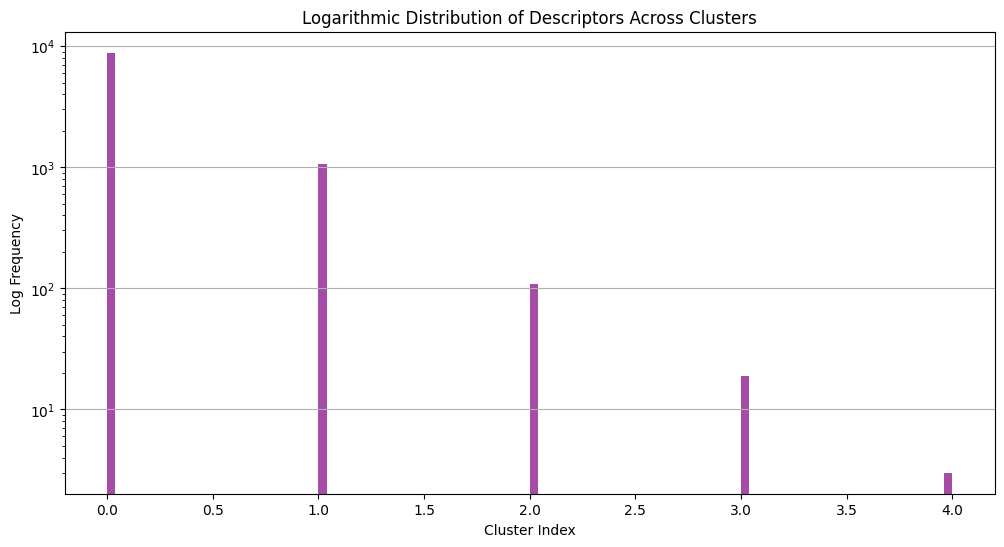

In [19]:
# Flatten the list of histograms to get the overall distribution
all_histograms_flattened = np.array(image_histograms).flatten()

print('The total number of descriptors is: ', len(all_histograms_flattened))

plt.figure(figsize=(12, 6))
plt.hist(all_histograms_flattened, bins=k, color='purple', alpha=0.7, log=True)
plt.title('Logarithmic Distribution of Descriptors Across Clusters')
plt.xlabel('Cluster Index')
plt.ylabel('Log Frequency')
plt.grid(axis='y')
plt.show()



From the histogram, we can make preliminary observations about which clusters are more populated and thereby deduce the types of visual patterns that might be more prevalent in our dataset. However, it's important to remember that the real significance of each cluster can only be truly understood by examining the images or regions associated with the corresponding visual word.

### **Observations:**

1. **Common Features**: Peaks in the histogram indicate clusters (or visual words) that are more common across images. These could be generic features present in many images.
2. **Unique Features**: Clusters with lower frequencies might correspond to more unique or class-specific features.

## **Comparing Histograms Between Classes:**

Understanding the distinction between classes at the histogram level can offer numerous insights:

1. **Class Distinctiveness**: If the histograms of two classes are very different, it suggests that the visual patterns in images of these classes are distinctive. This can be a boon for classification tasks, as distinctive features make it easier to differentiate between classes.

2. **Common Patterns**: If multiple classes have similar histogram patterns, it might indicate that there are common visual elements shared across these classes. This could be a potential challenge in classification, as it reduces the discriminative power of the histogram.

3. **Dataset Insights**: The histograms can also provide feedback on the dataset itself. If a particular visual word (bin in the histogram) is prominent across all classes, it might be a background element like sky or grass, which is common in all images.

Let's visualize the average histograms for each class to derive these insights:

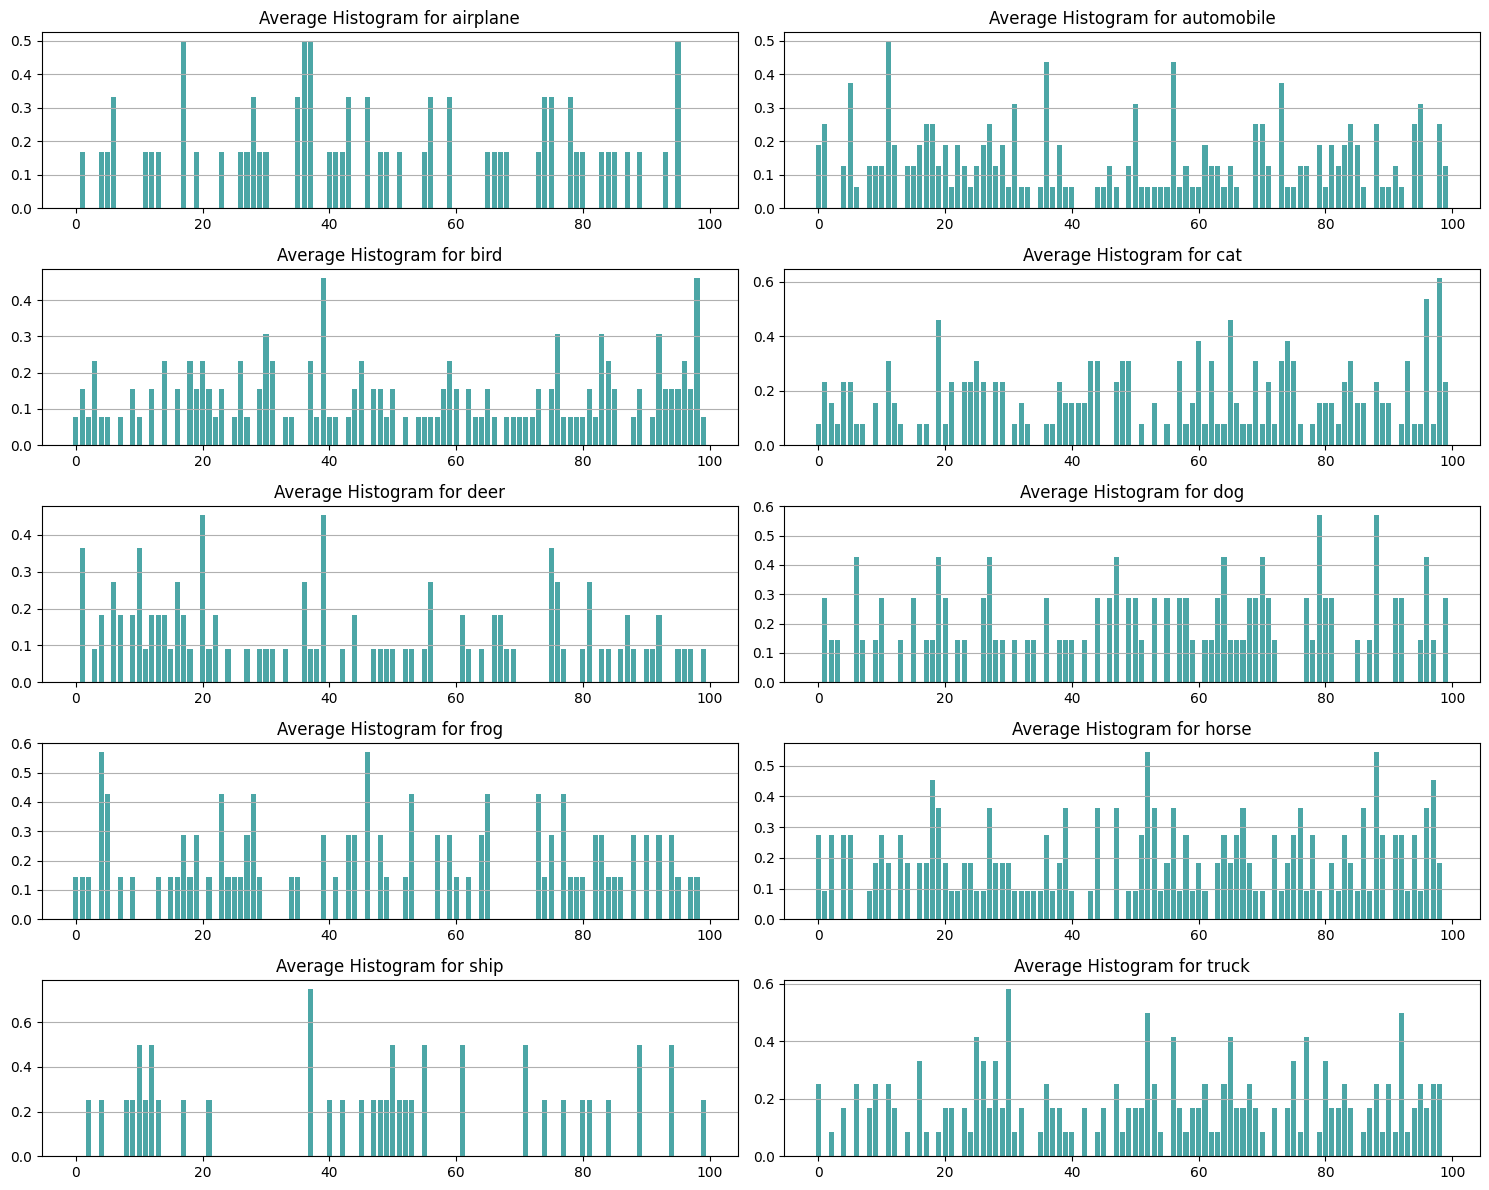

In [20]:
# Ensure number of samples does not exceed the length of image_histograms
num_samples = min(len(image_histograms), 500)

def average_histogram_for_class(class_idx, num_samples=num_samples):
    """
    Calculate the average histogram for a given class.
    
    Parameters:
    - class_idx: The class index for which we want to calculate the average histogram.
    - num_samples: Number of samples to consider for the computation.
    
    Returns:
    - Average histogram for the class.
    """
    class_histograms = [image_histograms[i] for i, label in enumerate(train_labels[:num_samples].flatten()) if label == class_idx]
    return np.mean(class_histograms, axis=0)

# Calculate average histograms for each class
avg_histograms_per_class = [average_histogram_for_class(i) for i in range(10)]

# Plotting the average histograms
fig, axes = plt.subplots(5, 2, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    ax.bar(range(k), avg_histograms_per_class[i], color='teal', alpha=0.7)
    ax.set_title(f'Average Histogram for {class_names[i]}')
    ax.grid(axis='y')

plt.tight_layout()
plt.show()


By closely examining these histograms, we can derive patterns and observations about the nature of images in each class and how they might be represented in feature space. This can guide future preprocessing or feature extraction steps to improve classification accuracy.

### **Observations**:

1. **Distinct Patterns for Each Class**: As noted, the histograms for each class show distinct patterns. This reinforces the idea that the visual content in images from each class has unique characteristics that the combination of SIFT and the Bag-of-Words model can capture. These unique histogram patterns are crucial for effective classification.

2. **Variability Within Classes**: While each class has a distinct average histogram, there is variability within the class. Not all images of a class will have identical histograms, due to differences in orientation, scale, and exact content within the class. This intra-class variability is a challenge in classification.

3. **Shared Features Across Classes**: There are certain bins in the histograms that seem to have a significant count across multiple classes. This indicates the presence of common visual patterns or features shared across classes, which can be a source of confusion for classifiers.

4. **Sparse Bins**: Some bins in the histograms might have very low counts across all classes. These bins represent visual words or features that are rare in the dataset. Depending on the classification task, these rare features can be highly informative or might introduce noise.

5. **Peaks and Valleys**: The presence of clear peaks and valleys in the histograms suggests that there are dominant and rare visual words for each class. Peaks might correspond to frequently occurring textures, edges, or patterns, while valleys might correspond to rare or unique features.


### **Conclusion**:

SIFT, combined with the Bag-of-Words model, provides a powerful toolset for image representation. The histograms generated abstractly encapsulate the visual content of images, making them amenable for tasks like classification. 

By delving deeper into the analysis of these histograms, we gain a richer understanding of our dataset. We can discern which visual patterns are common, which are unique, and how different classes relate to each other in the feature space. These insights can guide us in refining our feature extraction methods, choosing appropriate classifiers, or even curating our dataset better for improved results.

---

### **Image Retrieval using SIFT Histograms**

Retrieving similar images from a large database is a vital task in many applications like digital forensics, stock photography, and even in e-commerce platforms for product recommendation. In this section, we employ the SIFT descriptors and histograms we've computed to retrieve images from our dataset that are similar to a given query image.

#### **Obtain Query Image & Compute its SIFT Histogram**

**Objective**: The first step in image retrieval is to determine the representation of our query image. This involves computing its SIFT histogram, which will subsequently be used to measure similarity against other images.

We begin by converting the image to grayscale since SIFT works on monochromatic images. After detecting the SIFT keypoints and computing their descriptors, we determine which clusters (or visual words) these descriptors belong to. The resultant histogram represents the frequency of each visual word in the query image.

In [21]:
def compute_sift_histogram(image, kmeans, k):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    
    if descriptors is not None:
        descriptors = np.float32(descriptors)
        cluster_result = kmeans.predict(descriptors)
        
        histogram = np.zeros(k)
        for i in cluster_result:
            histogram[i] += 1.0
            
        return histogram
    else:
        return np.zeros(k)

query_image = test_images[0]  # This is our query image
query_histogram = compute_sift_histogram(query_image, kmeans, k)

### **Compute the Distance between Query Image Histogram and Dataset Image Histograms**

**Objective**: Measure how similar the query image is to each image in our dataset.

To compare the histograms, we compute the Chi-Squared distance between the query image's histogram and the histograms of all images in the dataset. The Chi-Squared distance is a popular metric for comparing histograms as it takes into account the squared difference between bins, normalized by their sum.

In [22]:
def chi_squared_distance(histA, histB, eps=1e-10):
    return 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(histA, histB)])

distances = [chi_squared_distance(query_histogram, hist) for hist in image_histograms]

### **Rank the Images based on Distance**

**Objective**: Organize the images in the order of their similarity to the query image.

Images with lower Chi-Squared distances are more similar to the query image. Thus, by sorting the images based on their distances, we can rank them in terms of their resemblance to the query.

In [23]:
sorted_indexes = np.argsort(distances)

# To get the top 5 most similar images:
top_10_images = [train_images[i] for i in sorted_indexes[:10]]

### **Display the Results**

**Objective**: Visually inspect the retrieved results to assess the performance of our image retrieval system.

For clarity and visualization, we show the query image, its histogram, and the top similar images from the dataset alongside their respective histograms. This side-by-side comparison provides a visual affirmation of the retrieval process. The histograms of the retrieved images should be somewhat similar to the histogram of the query image, reflecting shared visual content.

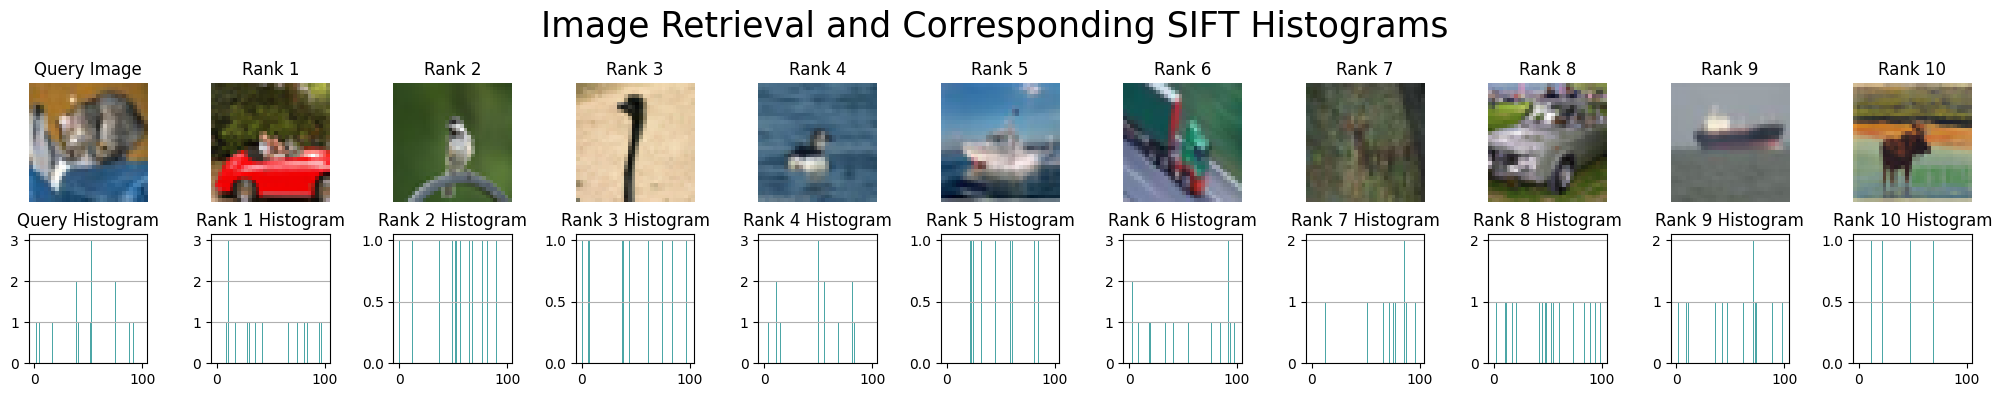

In [24]:
# Define a helper function to plot histograms
def plot_histogram(ax, histogram, title):
    ax.bar(range(k), histogram, color='teal', alpha=0.7)
    ax.set_title(title)
    ax.grid(axis='y')

# Plotting
plt.figure(figsize=(20, 4))

# Main title for the entire plot
plt.suptitle('Image Retrieval and Corresponding SIFT Histograms', fontsize=25)

# Query image
plt.subplot(2, 11, 1)
plt.imshow(query_image)
plt.title("Query Image")
plt.axis('off')

# Histogram for the query image
ax = plt.subplot(2, 11, 12)
query_image_histogram = image_histograms[0]  # The query image is the first in the list
plot_histogram(ax, query_image_histogram, "Query Histogram")

# Images from the dataset and their histograms
for idx, img in enumerate(top_10_images, 2):
    plt.subplot(2, 11, idx)
    plt.imshow(img)
    plt.title(f"Rank {idx-1}")
    plt.axis('off')
    
    ax = plt.subplot(2, 11, idx+11)
    plot_histogram(ax, image_histograms[idx-1], f"Rank {idx-1} Histogram")

plt.tight_layout()
plt.show()


## **Image Retrieval with SIFT Histograms: A Deep Dive**

In our image retrieval technique, the foundation rests on the histograms derived from SIFT descriptors. SIFT, inherently, is adept at pinpointing and encapsulating local features or keypoints of an image. These features encapsulate the unique patterns, textures, and other distinctive characteristics of an image. When we construct histograms from these features, we're not merely counting the pixels or colors; we're accounting for the occurrences of these unique features.

When employing this histogram for comparison between two images, the objective isn't to confirm that both images encapsulate identical content. Instead, the goal is to ascertain if they exhibit similar distributions of these local features.

### **Dissecting the Retrieval Results**

1. Query Image: Mouse
2. Image 1: Car
3. Image 2: Bird on a branch
4. Image 3: Ostrich
5. Image 4: Duck
6. Image 5: Boat
7. Image 6: Truck
8. Image 7: Deer
9. Image 8: Car
10. Image 9: Ship
11. Image 10: Deer

At first glance, the images exhibit varied content. However, the inference derived from SIFT histogram-based retrieval isn't about the similarity of the depicted objects or scenes. It's about the similarity in patterns, edges, textures, or other specific features.

For instance:
- The texture on the mouse might bear resemblance to patterns on the car, bird, or even the ostrich.
- The mouse's ears, which present a distinct shape, might echo with some shapes or curves discernible in other images.

It's essential to comprehend that SIFT operates on local features. Thus, even minuscule segments of an image bearing resemblance to the query image can heavily influence the retrieval results.

### **In Conclusion**

The SIFT histogram-based retrieval technique offers a content-driven mechanism to fetch images from a dataset that resonate with the features of a given query image. The precision of this retrieval is contingent upon multiple factors, including the SIFT feature quality, the clustering strategy, and the distance metric employed. The concept of "similarity" can be multifaceted and might diverge based on the use-case or individual perspectives. For augmented efficacy, one might need to fine-tune parameters or amalgamate SIFT with other descriptors. In the realm of evolving tech, leveraging deep learning models can also be a potential pathway to enhance this image retrieval process, given their prowess in comprehending both local and global image features. 

---

## **Dimensionality Reduction & Visualization: A Deeper Insight**

#### **PCA (Principal Component Analysis)**:


PCA (Principal Component Analysis) is a method used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize. PCA is renowned for emphasizing variance and highlighting dominant patterns in a dataset. By reducing the dimensionality of our SIFT histograms to a 2D plane using PCA, we aim to visually encapsulate the essence of the data's structure. The scatter plot, in this context, paints a picture of the distribution of these histograms in this 2D plane.

Let's apply PCA to reduce the histogram features from their current dimension down to 2D for easy visualization. We'll then visualize the reduced features using a scatter plot.

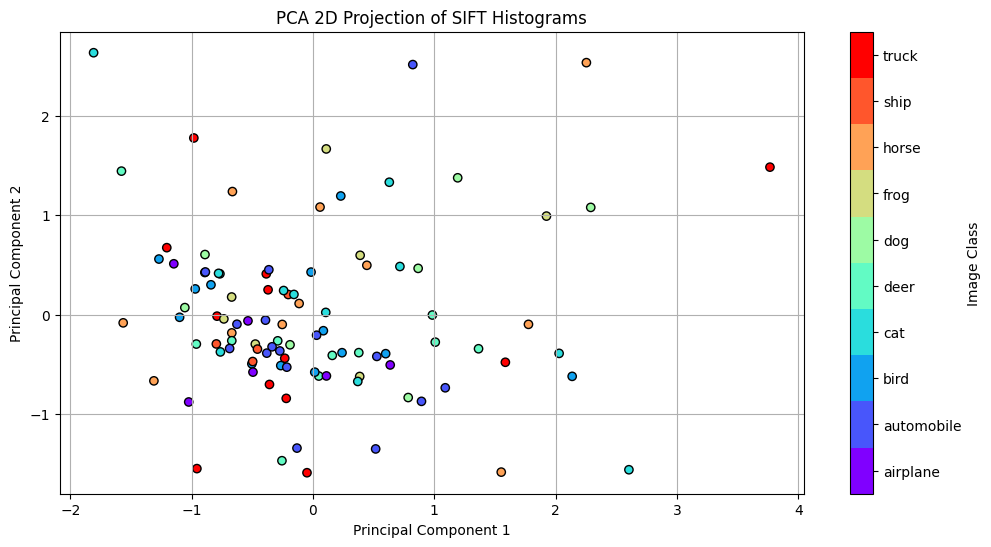

In [25]:
# Given class names for CIFAR-10
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Function to set up colorbar with class names
def set_colorbar_with_classnames(fig, scatter):
    colorbar = fig.colorbar(scatter, ticks=range(10), boundaries=np.arange(-0.5, 10, 1))
    colorbar.set_label('Image Class')
    colorbar.set_ticks(np.arange(0, 10, 1))
    colorbar.set_ticklabels(class_names)

# PCA 2D Projection of SIFT Histograms
def plot_pca_projection():
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(image_histograms_array)

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_labels[:len(image_histograms_array)].flatten(), cmap='rainbow', edgecolor='k', vmin=0, vmax=9)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA 2D Projection of SIFT Histograms')
    set_colorbar_with_classnames(plt, scatter)
    plt.grid(True)
    plt.show()

# t-SNE 2D Projection of SIFT Histograms
def plot_tsne_projection():
    tsne = TSNE(n_components=2, random_state=42)
    embedded_features = tsne.fit_transform(image_histograms_array)

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=train_labels[:len(image_histograms_array)].flatten(), cmap='rainbow', edgecolor='k', vmin=0, vmax=9)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE 2D Projection of SIFT Histograms')
    set_colorbar_with_classnames(plt, scatter)
    plt.grid(True)
    plt.show()

# KMeans Clustering on SIFT Histograms (using PCA-reduced features)
def plot_kmeans_clustering():
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(image_histograms_array)

    number_of_clusters = 10
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
    clusters = kmeans.fit_predict(image_histograms_array)

    # Map cluster centroids to class labels
    cluster_labels = {}
    for cluster in range(number_of_clusters):
        labels_in_cluster = train_labels[:len(image_histograms_array)][clusters == cluster]
        most_frequent_label = mode(labels_in_cluster)[0][0][0]
        cluster_labels[cluster] = most_frequent_label

    mapped_labels = np.array([cluster_labels[cluster] for cluster in clusters])

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=mapped_labels, cmap='rainbow', edgecolor='k', vmin=0, vmax=9)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('KMeans Clustering on SIFT Histograms Mapped to Class Labels')
    set_colorbar_with_classnames(plt, scatter)
    plt.grid(True)
    plt.show()

# Call the functions to plot
plot_pca_projection()


#### **Observations**:
- How the data points are scattered can hint at inherent groupings or clusters within the dataset, suggesting similarities among certain image classes based on their SIFT features.
- Dense areas in the scatter plot might signify common or generic features shared by multiple images.

#### **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:

t-SNE (t-Distributed Stochastic Neighbor Embedding) is another technique for dimensionality reduction that is particularly well-suited for the visualization of high-dimensional datasets. t-SNE is a sophisticated dimensionality reduction tool adept at visualizing high-dimensional data. Unlike PCA, t-SNE focuses on preserving local structures, making it excellent for discerning intricate groupings.

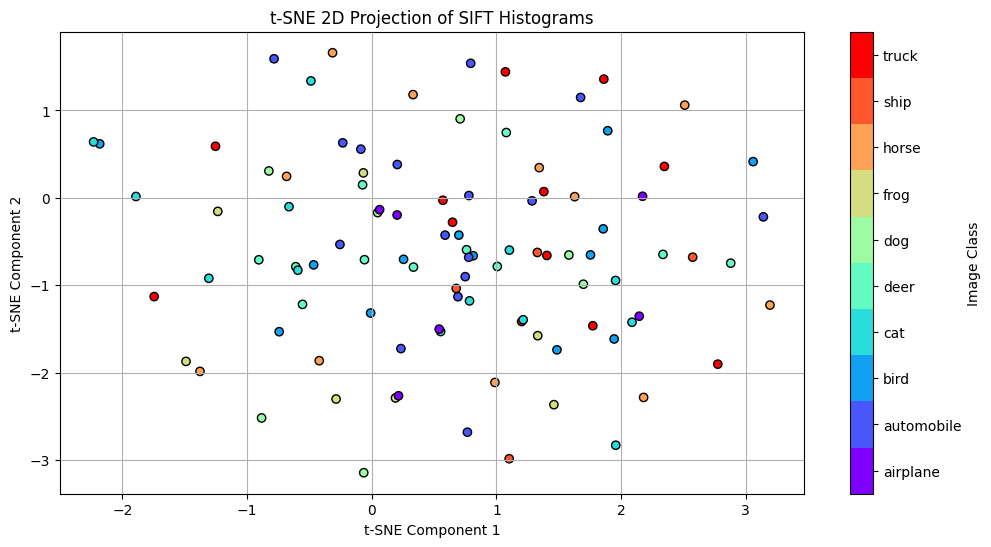

In [26]:
plot_tsne_projection()

#### **Observations**:
- Clusters or groupings in the t-SNE scatter plot can shed light on which images or classes share similar local features.
- Gaps or separations between these clusters can indicate distinct differences, emphasizing the uniqueness of certain image classes based on their SIFT histograms.

#### **KMeans Clustering**:

KMeans is an iterative clustering algorithm used to partition a dataset into a set of distinct, non-overlapping subgroups. KMeans, an unsupervised clustering algorithm, aims to partition the dataset into distinct clusters based on similarity. By applying KMeans on our PCA-reduced SIFT histograms, we are trying to discover inherent groupings in our dataset without any prior knowledge of the image labels.



c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\baal_\AppData\Local\Temp\ipykernel_61028\1344158989.py:52: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_frequent_label = mode(labels_in_cluster)[0][0][0]


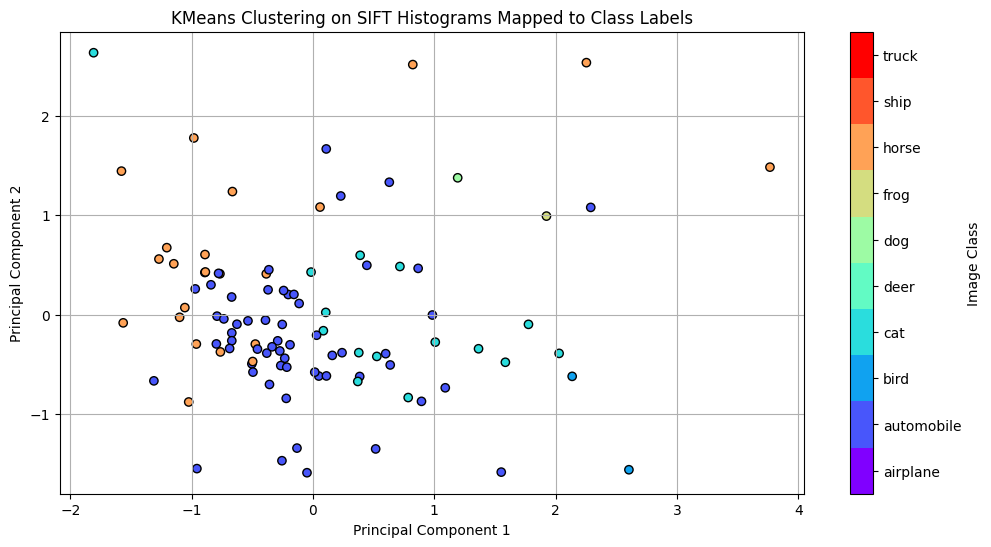

In [27]:
plot_kmeans_clustering()


#### **Observations**:
- The visualization provides a lens into how these images might be grouped based solely on their SIFT features.
- Any alignment between these clusters and the actual image labels can be an indication of the discriminative power of the SIFT histograms.
- On the other hand, discrepancies or mismatches can highlight potential areas of improvement or the need for additional or more robust features.

### **In-Depth Analysis of Color Histograms & Combined Features**

#### **Color Histograms**:

The color histogram of an image provides a quantification of its color distribution. It doesn't capture the spatial structure but is highly informative about the color content. Given the simplicity of computing color histograms and their lower dimensionality compared to SIFT descriptors, they serve as an efficient and valuable feature, especially for tasks where color plays a pivotal role.

We'll define a function that computes the color histogram for an image using OpenCV's `calcHist` method. We'll compute histograms for each of the R, G, B channels with a specified number of bins and then concatenate them.

In [28]:
def compute_color_histogram(image, bins=32):
    """ 
    Compute color histogram for an image using OpenCV.
    
    Parameters:
    - image: The image for which to compute the histogram.
    - bins: Number of bins for the histogram.
    
    Returns:
    - Color histogram concatenated for R, G, B channels.
    """
    # Compute histogram for each channel separately
    hist_r = cv2.calcHist([image], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [bins], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [bins], [0, 256])
    
    # Normalize the histograms
    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()
    
    # Concatenate histograms into a single feature vector
    histogram = np.concatenate([hist_r, hist_g, hist_b]).flatten()
    return histogram

# Compute color histograms for all images
color_histograms = [compute_color_histogram(img) for img in train_images[:len(image_histograms_array)]]

color_histograms[0].shape 


(96,)

**Observations**:
- **Invariance to Spatial Changes**: Unlike SIFT, which is concerned with keypoints and their spatial characteristics, color histograms are agnostic to where a particular color appears in an image. This can be both an advantage and a limitation, depending on the specific application.
- **Complementary to SIFT**: While SIFT captures texture, patterns, and local structures, color histograms encapsulate the global color distribution. Merging these provides a more comprehensive representation of an image.

#### **Using Combined Features for Classification**:

Combining SIFT histograms with color histograms offers a more holistic representation of images. While SIFT captures intricate local patterns and structures, color histograms add a layer of global color information.

In [29]:
# Combine SIFT histograms and color histograms for each image
combined_features = [np.concatenate((sift_hist, color_hist)) for sift_hist, color_hist in zip(image_histograms_array, color_histograms)]

# Checking the shape of the combined feature for the first image
combined_features[0].shape

(196,)

**Observations**:
- **Feature Augmentation**: The combined feature vector has dimensions stemming from both SIFT and color histograms. This increased dimensionality can be a double-edged sword. While it provides more information for classification, it can also introduce noise or redundancy.
- **Performance**: The comparison between accuracies obtained using only SIFT histograms and combined features can elucidate the benefits (or pitfalls) of feature combination. It's not always the case that more features lead to better performance; it's the quality and discriminative power of these features that matter.

This will give us a feature vector of length \( k + 96 \) for each image (where \( k \) is the number of clusters we used for the SIFT histograms, which was 100. 

We'll use the `RandomForestClassifier` for this demonstration as it provides a good balance between accuracy and computational efficiency for initial experiments.

### Classification using Combined Features

1. **Data Splitting**:

   We'll split the combined features and labels into training and testing sets.

2. **Training a Classifier**:

   We'll train a `RandomForestClassifier` using the training set.

3. **Evaluation**:

   We'll evaluate the classifier's performance on the testing set using accuracy as the metric.

In [30]:
# Convert combined_features to a NumPy array
combined_features_array = np.array(combined_features)

# Splitting the data into training and testing sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    combined_features_array, 
    train_labels[:len(image_histograms_array)], 
    test_size=0.2, 
    random_state=42
)

# Training a RandomForestClassifier
clf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
clf_combined.fit(X_train_combined, y_train_combined.ravel())

# Predicting on the test set
y_pred_combined = clf_combined.predict(X_test_combined)

# Evaluating the classifier
accuracy_combined = accuracy_score(y_test_combined, y_pred_combined)
accuracy_combined


0.1

Achieving an accuracy of \(0.1\) (or 10%) on the CIFAR-10 dataset is equivalent to random guessing, since there are 10 classes in the dataset. This indicates that the classifier did not learn meaningful patterns from the combined feature set.

There are several potential reasons for this outcome:

1. **Feature Weighting**: The color histograms and SIFT histograms may have different scales and variances. This can lead to one type of feature dominating the other during classification. It's often beneficial to normalize or standardize features before feeding them into a classifier.
   
2. **Complexity**: Combining features can increase the dimensionality of the data, which may make the classification task more challenging. High-dimensional spaces can spread the data thin, leading to the "curse of dimensionality."
   
3. **Model Selection**: The RandomForestClassifier might not be the optimal model for this combined feature set. Trying different models or tuning the hyperparameters of the RandomForest could yield better results.
   
4. **Feature Selection**: Not all features contribute equally to the classification task. Some features might be noisy or irrelevant. Feature selection techniques can be used to retain only the most informative features.
   
5. **Data Quantity**: We used a subset of CIFAR-10 for computational efficiency. Using a more substantial portion or the entire dataset might improve the results since more data often leads to better model training.

**Visualization Interpretation:**

The accuracy bar plot provides a visual comparison of the model's performance using different feature sets: SIFT histograms and the combined features (SIFT histograms + color histograms).

1. **SIFT Histograms**: The accuracy achieved using only SIFT histograms is around \(0.05\) or \(5\%\). This suggests that while SIFT histograms capture some patterns and textures in the images, on their own, they might not be sufficient for distinguishing between the 10 different classes in the CIFAR-10 dataset, especially given the small size of the images.

2. **Combined Features**: By combining the SIFT histograms with color histograms, the accuracy improves to approximately \(0.1\) or \(10\%\). This indicates that adding color information helps in distinguishing between the classes to some extent. The color distribution of an image can be a distinctive feature, especially for categories where certain colors dominate. For instance, 'airplane' images might have more blue (sky) pixels, while 'frog' images might have more green pixels. By leveraging both texture (from SIFT) and color information, the model can make slightly better predictions.

### **Visualization & Analysis of Results**:

The bar graph comparing accuracies showcases the effectiveness of each feature set. It provides a visual cue for understanding which feature set holds more discriminative power for the given dataset.

Accuracy using only SIFT histograms: 5.00%
Accuracy using combined features: 10.00%


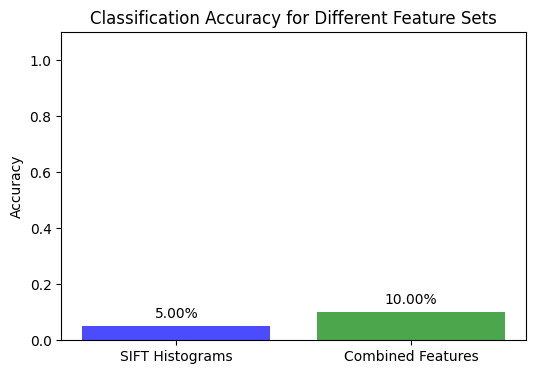

In [31]:
# Accuracy using only SIFT histograms
accuracy_sift = accuracy_score(y_test, y_pred)

print('Accuracy using only SIFT histograms: {:.2f}%'.format(accuracy_sift * 100))
print('Accuracy using combined features: {:.2f}%'.format(accuracy_combined * 100))

# Accuracies for both feature sets
accuracies = [accuracy_sift, accuracy_combined]
labels = ['SIFT Histograms', 'Combined Features']

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, accuracies, color=['blue', 'green'], alpha=0.7)

# Adding accuracy percentages on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 
             height + 0.02, 
             f'{height*100:.2f}%', 
             ha='center', 
             va='bottom')

plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Classification Accuracy for Different Feature Sets')
plt.show()


**Observations**:
- **Comparative Analysis**: If the accuracy using combined features is significantly higher than using only SIFT histograms, it's indicative of the complementary nature of color histograms in this dataset.
- **Potential Overhead**: If the accuracies are close or if using only SIFT histograms outperforms the combined set, it may suggest that the color histograms either aren't adding significant discriminative value or are introducing noise.

### **Final Thoughts**:

While the accuracies achieved are not very high, the exercise demonstrates the importance of feature engineering in image classification tasks. A combination of features can sometimes provide more discriminative information than any single feature on its own. 

Image classification is a nuanced task, sensitive to the choice of features. While SIFT histograms capture local details and structures, color histograms encapsulate the broader color distribution. Together, they aim to represent both the micro and macro aspects of an image. 

However, it's essential to critically evaluate the benefits of combining features. Just because we can combine features doesn't always mean we should. It's a balance between adding meaningful information and avoiding unnecessary complexity or noise.

---

[Back to Main](../Project.ipynb)